In [6]:
import onnxruntime
onnx_model_path = 'saved_models/AntiSpoofing_bin_128.onnx'

In [7]:
session = onnxruntime.InferenceSession(
    onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

onnxruntime.get_device()

'GPU'

In [8]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

input_name, output_name

('input', 'output')

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img0_path = "CelebA_Spoof_crop/data256/test/4930/live/494536.png"
img1_path = "CelebA_Spoof_crop/data256/test/4930/spoof/495600.png"

def preprocessing(img, new_size=128):
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(new_size)/max(old_size)
    new_shape = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_shape[1], new_shape[0]))

    delta_w = new_size - new_shape[1]
    delta_h = new_size - new_shape[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    img = cv2.copyMakeBorder(img, top, bottom, left, right, 
                              cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img = img.transpose(2, 0, 1).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

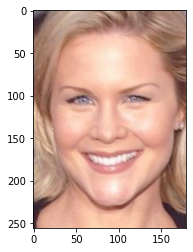

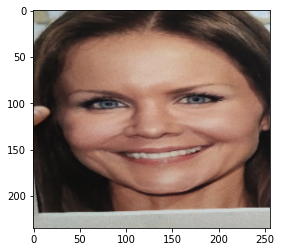

((1, 3, 128, 128), (1, 3, 128, 128))

In [10]:
img0 = cv2.cvtColor(cv2.imread(img0_path), cv2.COLOR_BGR2RGB)
plt.imshow(img0)
plt.show()
img0 = preprocessing(img0)


img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
img1 = preprocessing(img1)

img0.shape, img1.shape

In [11]:
pred0 = session.run([], {input_name: img0})
softmax(pred0)

array([[[0.9959478 , 0.00405218]]], dtype=float32)

In [88]:
pred1 = session.run([], {input_name: img1})
softmax(pred1)

array([[[5.0740244e-05, 9.4641566e-01, 5.3533684e-02]]], dtype=float32)